# Case with no capital tax and no markups

Here we do the simulation of the case where there is no capital tax, and as a result, the level of capital adjusts with the interest rate. This is done for the economy without markups.

In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using Revise
using Aiyagari
using StructArrays
using Plots
using ProgressMeter
using DelimitedFiles
using FastClosures

┌ Info: Precompiling Aiyagari [7fa42512-05e8-4b48-85a4-0694c1caf184]
└ @ Base loading.jl:1317


In [2]:
ProgressMeter.ijulia_behavior(:clear);
pgfplotsx();
default(label = "", lw = 2, dpi = 300, left_margin = 0Plots.mm, format=:svg);

In [3]:
_LOAD_GUESSES = true
_SAVE_GUESSES = false
_ITERS = 1

1

## Benchmark calibration

In [4]:
# Dirk and Kurt's calibration (almost)
e = let
    P, z_vals = let
        ar1 = 0.9695
        sigmaP = sqrt(0.0384)/(1.2)
        sigmaIID = sqrt(0.0522)/(1.2)
         calibration(5, 2 , ar1, sigmaP, sigmaIID)
    end
    # Technology
    t = let
        θ = 0.3
        ls = 1 - θ
        δ = 0.1
        #α1, A1 = get_tech_params(1, θ = θ)
        A1 = 1.0
        α1 = 0.3
        Technology(f = CobbDouglas(α = α1), δ = δ)
    end
    # Households
    h = let
        ies = 1.0
        β = 0.99 #* (1 + g)^(1 - 1/ies)
        Household(
            u = EZ(ies = 1.0, ra = 5.5),
            v = GHH(θ = 1.0, ν = 0.2),
            P = P, z_grid = z_vals, β = β, a_max = 100.0)
    end
    Economy(h = h, t = t)
end

Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1

In [5]:
r_range = (-0.0172, -0.0171) # narrowing the range
@time laissez_faire = solve_laissez_faire(e;
    r_range = r_range,
    tol =  (value_function = 1e-10, distribution = 1e-13)
)

Progress:  19 	 Time: 0:04:44
  r:       -0.017178158569335928
  excess:  1.3117266375317627e-6

298.932913 seconds (2.85 G allocations: 43.566 GiB, 6.31% gc time, 5.23% compilation time)


r=-0.01717815856933593, b=0.0, k=6.902156580943709, transfer=0.0,  y=1.9054977262551143, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1

## New stationary outcome

In [6]:
b_target = laissez_faire.y * 0.60

1.1432986357530686

In [7]:
r_range_2 = (-0.0152, -0.0148)  # narrowing the range
@time final_eq = @closure solve_new_stationary_equilibrium_given_k_b(
        laissez_faire; r_range = r_range_2, tol = (value_function = 1e-7, distribution = 1e-8)
    ) do (r)
        # returns (k, b) consistent with r and no capital taxes
        t = get_t(laissez_faire)
        b = b_target
        rK = rK_from_r(;t, r)
        mpk = mpk_from_after_tax_rK(t, rK)
        k = k_from_mpk(t; mpk, laissez_faire.n)
        return (k, b)
    end

Progress:  17 	 Time: 0:01:46
  tr:      0.0025568388674737236
  excess:  -8.477799796047236e-5
  r:       -0.015021142578124995

107.517753 seconds (1.06 G allocations: 15.960 GiB, 6.42% gc time, 0.42% compilation time)


r=-0.015021142578124997, b=1.1432986357530686, k=6.653242778527226, transfer=0.0025568388674737375,  y=1.8846165648986157, Economy: EZ(ies = 1.0, ra = 5.5), β=0.99, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=10000, a_max=100.0, a_min=0.0, CobbDouglas(α=0.3), A=1.0, δ=0.1

## Transition

In [8]:
T = 100
H = 50;

In [9]:
# Smooth debt policy
ρB = 0.9
b_list = Array{Float64,1}(undef, T + H)
b_list[1] = 0.0
b_list[2] = laissez_faire.y * 0.05
b_list[T:end] .= b_target
for i in 3:T-1
    b_list[i] = b_list[2] * ρB^(i-2) + (1 - ρB^(i-2)) * b_target
end

In [10]:
r_path = nothing
if _LOAD_GUESSES
    r_path = try
        # load the transfer vector from previous iterations
        readdlm(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmpINEFF001.txt"))[:,1]
    catch
        nothing
    end
end;

In [11]:
function generate_k_b_no_τk(laissez_faire, final, b_list)
    f = @closure (r, i) -> begin
        if i <= length(b_list)
            b = b_list[i]
        else
            b = final.b
        end
        t = get_t(laissez_faire)
        rK = rK_from_r(;t, r)
        mpk = mpk_from_after_tax_rK(t, rK)
        k = k_from_mpk(t; mpk, laissez_faire.n)
        return (k, b)
    end
    return f
end

generate_k_b_no_τk (generic function with 1 method)

In [12]:
my_k_b_fun = generate_k_b_no_τk(laissez_faire, final_eq, b_list)

#3 (generic function with 1 method)

In [13]:
transition = solve_transition(
    my_k_b_fun,
    laissez_faire,
    final_eq;
    init_r_path = r_path,
    path_length = T + H,
    iterations = _ITERS,
    m = 10,
    beta = -0.01
);

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     1     7.638859e-06              NaN


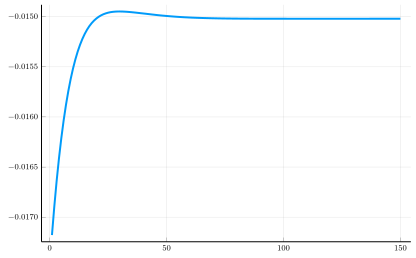

In [14]:
plot(transition.path.r)

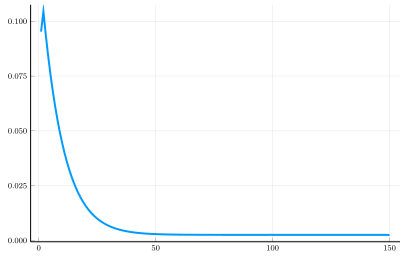

In [15]:
plot(transition.path.transfer)

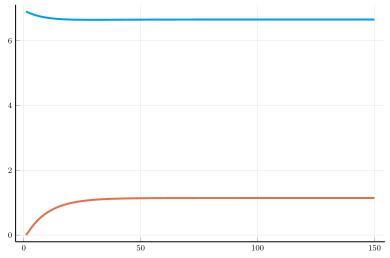

In [16]:
plot(transition.path.k)
plot!(transition.path.b)

In [17]:
_SAVE_GUESSES && open(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmpINEFF001.txt"), "w") do io
    writedlm(io, transition.path.r)
end

false

## Satistics and Plots

In [18]:
println("INITIAL STEADY STATE")
println("=====================")
summary_statics(laissez_faire)

INITIAL STEADY STATE

FISCAL
debt: 0.0
debt over y (%): 0.0
transfer over y (%): 0.0
interest rate: -0.01717815856933593

AGGREGATES
capital over y: 3.6222329136590243

HOUSEHOLDS
standard deviation of log c (*100): 67.85543645314476

mass of constrained households (%): 2.0246335453659885
mean wealth (over y): 3.6222336020495782
median wealth (over y): 1.7882150946587314
share of wealth per asset quintiles:
   [0.7134171812781288, 4.269576046919197, 10.13824675086585, 23.484472982341032, 61.39428703859579]


In [19]:
println("FINAL STEADY STATE")
println("=====================")
summary_statics(final_eq, path = transition.path, laissez_faire = laissez_faire)

FINAL STEADY STATE

FISCAL
debt: 1.1432986357530686
debt over y (%): 60.66478757786856
transfer over y (%): 0.13566891616551638
interest rate: -0.015021142578124997

AGGREGATES
capital over y: 3.530289875641172

HOUSEHOLDS
standard deviation of log c (*100): 66.69811044494878

mass of constrained households (%): 1.5911031348608833
mean wealth (over y): 4.1368927672042135
median wealth (over y): 2.1347182083317526
share of wealth per asset quintiles:
   [0.7679135697255683, 4.501772025480733, 10.543368067854614, 23.645037066381583, 60.541909270557504]

TRANSITION
welfare gain in transition: min = 2.198730250526282,  max = 6.269114823383015,  mean = 2.982973137114294
mean welfare gain per asset decile:
 [4.642491405661201, 3.707401140080132, 3.1094006887594614, 2.8419837659683584, 2.71202440459861, 2.547688696620047, 2.403514750328091, 2.3175323104103334, 2.302627479676006, 2.3852941754316475]


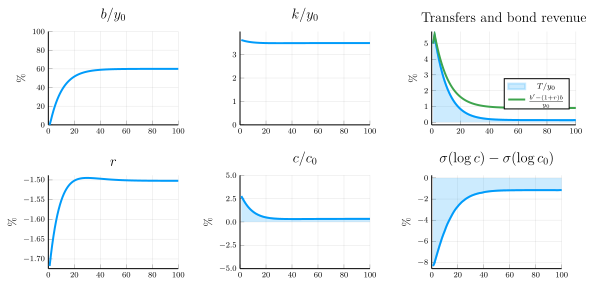

In [20]:
f1 = plot(do_plots(transition, laissez_faire)..., size = (800, 400))

In [21]:
savefig(f1, joinpath(@__DIR__, "..", "output", "figures", "transition_inefficient.pdf"))